In [1]:
import numpy as np
import matplotlib.pyplot as plt

Two steps of ICP:
1. data association
2. transformation

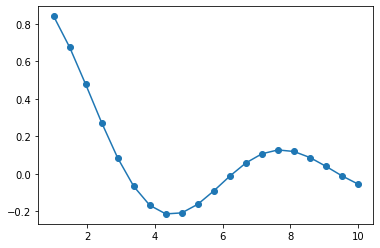

In [2]:
x = np.linspace(1, 10, 20)
y = 1/x*np.sin(x)

f, ax = plt.subplots()
ax.plot(x, y, '-o')
plt.show()


In [3]:
def transform_points(A, T):
    """
    Apply a 4x4 transformation matrix T to a set of 3D points A.
    """
    n = A.shape[0]
    ones = np.ones((n, 1))
    A_hom = np.hstack([A, ones])           # (n, 4)
    A_transformed = (T @ A_hom.T).T        # (n, 4)
    return A_transformed[:, :3]            # Drop homogeneous coordinate


A = np.column_stack((x, y))
A

array([[ 1.        ,  0.84147098],
       [ 1.47368421,  0.67537422],
       [ 1.94736842,  0.47753196],
       [ 2.42105263,  0.27252219],
       [ 2.89473684,  0.08441399],
       [ 3.36842105, -0.06676371],
       [ 3.84210526, -0.16777512],
       [ 4.31578947, -0.21372217],
       [ 4.78947368, -0.20817119],
       [ 5.26315789, -0.16190325],
       [ 5.73684211, -0.09056659],
       [ 6.21052632, -0.01168904],
       [ 6.68421053,  0.05840068],
       [ 7.15789474,  0.10720432],
       [ 7.63157895,  0.12780714],
       [ 8.10526316,  0.11950193],
       [ 8.57894737,  0.08725105],
       [ 9.05263158,  0.04016685],
       [ 9.52631579, -0.01064036],
       [10.        , -0.05440211]])

In [4]:
import numpy as np

def transform_matrix(tx, ty, tz, rx, ry, rz, order='zyx', degrees=True):
    """
    Build a 4x4 homogeneous transformation matrix.

    Parameters
    ----------
    tx, ty, tz : float
        Translation along x, y, z.
    rx, ry, rz : float
        Rotations about the x, y, z axes (Euler angles).
    order : str, optional
        The order in which rotations are applied. Default 'zyx' (R = Rz * Ry * Rx).
        Any permutation of 'x', 'y', 'z' is allowed (e.g. 'xyz', 'zyx', 'yxz', ...).
    degrees : bool, optional
        If True (default), rx,ry,rz are in degrees. If False, they are radians.

    Returns
    -------
    T : (4,4) ndarray
        Homogeneous transformation matrix:
            [ R  t ]
            [ 0  1 ]
    """
    if degrees:
        rx, ry, rz = np.deg2rad([rx, ry, rz])

    # Rotation matrices about principal axes
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx),  np.cos(rx)]])
    Ry = np.array([[ np.cos(ry), 0, np.sin(ry)],
                   [0,           1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz),  np.cos(rz), 0],
                   [0,           0,          1]])

    mapping = {'x': Rx, 'y': Ry, 'z': Rz}
    order = order.lower()
    if len(order) != 3 or set(order) != {'x', 'y', 'z'}:
        raise ValueError("order must be a permutation of 'x','y','z', e.g. 'zyx'")

    # Compose rotations in the requested order: R = R_<order[0]> * R_<order[1]> * R_<order[2]>
    R = np.eye(3)
    for ax in order:
        R = R @ mapping[ax]

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = [tx, ty, tz]
    return T

T = transform_matrix(6, 2, 0, 0, 0, 45, order='zyx', degrees=True)


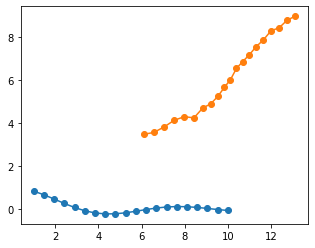

In [5]:
np.random.seed(0)

z = np.zeros_like(x)
A = np.column_stack((x, y, z))
A_aligned = transform_points(A, T)
A_aligned[:, 1] = A_aligned[:, 1] + np.random.normal(0, 0.1, size=A_aligned.shape[0])

points = A_aligned[:, :2]

f, ax = plt.subplots()

ax.plot(x, y, '-o')
ax.plot(points[:, 0], points[:, 1], '-o')


ax.set_aspect('equal')
plt.show()


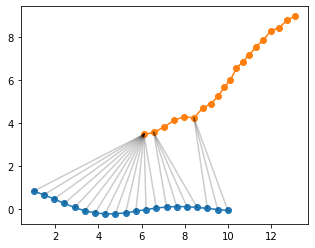

In [6]:
from scipy.spatial import KDTree

ref = np.array([x, y]).T



tree = KDTree(points)
distances, indices = tree.query(ref)

indices
f, ax = plt.subplots()

ax.plot(x, y, '-o')
ax.plot(A_aligned[:, 0], A_aligned[:, 1], '-o')

for i, idx in enumerate(indices):
    plt.plot([ref[i, 0], points[idx, 0]], [ref[i, 1], points[idx, 1]], 'k', alpha=0.2)

ax.set_aspect('equal')
plt.show()

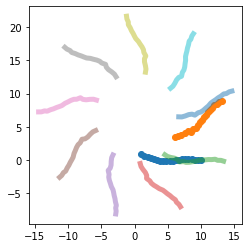

In [7]:
import numpy as np
from scipy.spatial import KDTree

def best_fit_transform(A, B):
    """
    Calculates the least-squares best-fit transform that maps points A to points B.
    Returns rotation matrix R and translation vector t.
    """
    assert A.shape == B.shape

    # Centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Center the points
    AA = A - centroid_A
    BB = B - centroid_B

    # Covariance matrix
    H = AA.T @ BB

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Translation
    t = centroid_B - R @ centroid_A

    return R, t

def icp(A, B, max_iterations=50, tolerance=1e-5):
    """
    Iterative Closest Point (ICP) algorithm for 2D points.
    Returns the final transformation matrix T, all intermediate transformations,
    distances, and the number of iterations.
    """
    src = np.copy(A)
    dst = np.copy(B)

    prev_error = float('inf')
    T_total = np.eye(3)
    transformations = []  # store intermediate transformation matrices

    for i in range(max_iterations):
        # Find nearest neighbors
        tree = KDTree(dst)
        distances, indices = tree.query(src)

        # Compute the best-fit transform
        R, t = best_fit_transform(src, dst[indices])

        # Build homogeneous transformation for this step
        T_step = np.eye(3)
        T_step[:2, :2] = R
        T_step[:2, 2] = t

        # Accumulate transformation
        T_total = T_step @ T_total

        # Store intermediate transformation
        transformations.append(T_total.copy())

        # Apply transformation to src
        src = (R @ src.T).T + t

        # Compute mean error
        mean_error = np.mean(distances)
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return T_total, transformations, distances, i

T_total, transformations, distances, i = icp(points, ref)


f, ax = plt.subplots()

ax.plot(x, y, '-o')

ax.plot(A_aligned[:, 0], A_aligned[:, 1], '-o')

posicionado = points.T
for i in range(len(transformations)):
    T = transformations[i]
    posicionado = T[:2, :2]@posicionado + T[:2, 2:3]
    ax.plot(posicionado[0], posicionado[1], linewidth=5, alpha=0.5)

ax.set_aspect('equal')
plt.show()


19


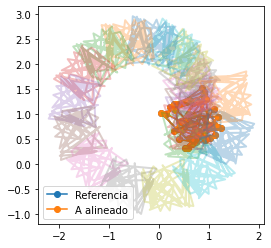

In [18]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

def best_fit_transform(A, B):
    assert A.shape == B.shape
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B
    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = centroid_B - R @ centroid_A
    return R, t

def icp(A, B, max_iterations=50, tolerance=1e-5):
    src = np.copy(A)
    dst = np.copy(B)
    prev_error = float('inf')
    T_total = np.eye(3)
    transformations = []

    for i in range(max_iterations):
        tree = KDTree(dst)
        distances, indices = tree.query(src)
        R, t = best_fit_transform(src, dst[indices])
        T_step = np.eye(3)
        T_step[:2, :2] = R
        T_step[:2, 2] = t
        T_total = T_step @ T_total
        transformations.append(T_total.copy())
        src = (R @ src.T).T + t
        mean_error = np.mean(distances)
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return T_total, transformations, distances, i

# Ejemplo de prueba
points = np.random.rand(50, 2)
theta = np.pi / 6
R_true = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t_true = np.array([0.5, 0.2])
ref = (R_true @ points.T).T + t_true

T_total, transformations, distances, i = icp(points, ref)
A_aligned = (T_total[:2, :2] @ points.T).T + T_total[:2, 2]


print(i)
# Gráfica
f, ax = plt.subplots()
ax.plot(ref[:, 0], ref[:, 1], 'o-', label='Referencia')
ax.plot(A_aligned[:, 0], A_aligned[:, 1], 'o-', label='A alineado')

posicionado = points.T
for T in transformations:
    posicionado = T[:2, :2] @ posicionado + T[:2, 2].reshape(2, 1)
    ax.plot(posicionado[0], posicionado[1], linewidth=2, alpha=0.3)

ax.set_aspect('equal')
ax.legend()
plt.show()
